In [27]:
import os
from glob import glob
import shutil


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split

# Problems facing in this project are:

* Dataset has only train data --> so we need to create the train and test
* It's maxiumum accuracy is 60% only --> so we create critical model
* Total classes 121 and Total images 30k


### All in together

In [2]:
# Generating csv file to gather data of images 

def generate_csv(root, img_ext = ['jpg', 'png', 'jpeg']):

    # create a dataframe to store the data we get from the file
    df = pd.DataFrame(columns = ['path', 'labels'])

    # os.listdir gives the folder name of the files
    for index, label in enumerate(os.listdir(root)):

            links = glob(f"{root}/{label}/*{img_ext}")           # glob used to get all information
            #print(len(links))

            # np.ones gives 1 to total number of links and multiply with index which starts from 0
            # np.ones(4)*3 = array([3, 3, 3, 3])
            # so by this we get both path for images and the labels in numbers till(0 - 120)
            temp_df = pd.DataFrame({'path': links, 'labels': np.ones(len(links))*index})

            df = pd.concat([df, temp_df], axis = 0)      # merge all in one
        
    return df

In [3]:
data = generate_csv('C:\\Users\\ritth\\code\\Data\\datasciencebowl\\train\\train')
data

,path,labels
0,C:\Users\ritth\code\Data\datasciencebowl\train...,0.0
1,C:\Users\ritth\code\Data\datasciencebowl\train...,0.0
2,C:\Users\ritth\code\Data\datasciencebowl\train...,0.0
3,C:\Users\ritth\code\Data\datasciencebowl\train...,0.0
4,C:\Users\ritth\code\Data\datasciencebowl\train...,0.0
...,...,...
420,C:\Users\ritth\code\Data\datasciencebowl\train...,120.0
421,C:\Users\ritth\code\Data\datasciencebowl\train...,120.0
422,C:\Users\ritth\code\Data\datasciencebowl\train...,120.0
423,C:\Users\ritth\code\Data\datasciencebowl\train...,120.0


### Split the dataset 

In [4]:
train_ds, test_ds = train_test_split(data, test_size = 0.2, random_state = 0, stratify = data["labels"])
train_ds, test_ds = train_ds.reset_index(drop=True), test_ds.reset_index(drop=True)
train_ds.shape, test_ds.shape

((24268, 2), (6068, 2))

In [5]:
train_ds.head()

,path,labels
0,C:\Users\ritth\code\Data\datasciencebowl\train...,8.0
1,C:\Users\ritth\code\Data\datasciencebowl\train...,104.0
2,C:\Users\ritth\code\Data\datasciencebowl\train...,90.0
3,C:\Users\ritth\code\Data\datasciencebowl\train...,35.0
4,C:\Users\ritth\code\Data\datasciencebowl\train...,110.0


### Create a new folder to store train and test in desktop

In [6]:
dest_folder_train = "C:\\Users\\ritth\\code\\Data\\datasciencebowl\\train_new"
dest_folder_test = "C:\\Users\\ritth\\code\\Data\\datasciencebowl\\test_new"

In [7]:
def copy_files(dest_folder, data):

    for pth in data.values[:, 0]:            # take the path to convert into images

        # 'C:\\Users\\ritth\\code\\Data\\datasciencebowl\\train\\train/siphonophore_physonect\\14249.jpg'
        # pth.split('/')[-1] = 'siphonophore_physonect\\14249.jpg'
        # ['siphonophore_physonect', '14249.jpg']
        folder_img = pth.split("/")[-1].split("\\")     
        folder, img = folder_img[0], folder_img[1]


        # folder join with the path Eg:[C:\Users\ritth\code\Data\datasciencebowl\train_new\trichodesmium_tuft]
        label_folder = os.path.join(dest_folder, folder)

        if not os.path.isdir(label_folder):                # if the folder does not exist 
            os.mkdir(label_folder)                         # creating the folder 
        shutil.copy(pth , label_folder)                    # copy the content of source(images) to destination(folder)

In [8]:
copy_files(dest_folder_train, train_ds)
copy_files(dest_folder_test, test_ds)

### Preprocessing the images

In [9]:
train_transform = transforms.Compose([
                                    transforms.Resize((50, 50)),           # resize will resize all the images into same scale(same pixels) given images size are small and big, so we take approximitily 50
                                    transforms.RandomResizedCrop(28),      # crop adjust the images to other images in features and we taken it as 28 smaller than resize
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        mean=[0.485, 0.456, 0.406],        # normalize have mean and standard deviation for color pic (red, green, blue)
                                        std=[0.229, 0.224, 0.225]) 
                                    ])
    
    
test_transform = transforms.Compose([
                                    transforms.Resize((50, 50)),
                                    transforms.CenterCrop(28),
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
                                   ])

### Load the data

In [10]:
# Load the training data
trainset = datasets.ImageFolder(dest_folder_train, transform = train_transform)
trainloader = DataLoader(trainset, batch_size = 64, shuffle = True)


# Load the test data
testset = datasets.ImageFolder(dest_folder_test,transform = test_transform)
testloader = DataLoader(testset, batch_size = 64, shuffle = False)

### Model

In [24]:
model = models.resnext50_32x4d(pretrained = True)

inputs = model.fc.in_features
outputs = len(trainset.classes)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

clf = nn.Sequential(
              nn.Dropout(0.30), 
              nn.Linear(inputs, outputs)
                  )

model.fc = clf

### Training and Validation

Epoch 1/30
Train loss: 3.4633
Test accuracy: 30.91%
Epoch 2/30
Train loss: 3.4257
Test accuracy: 31.80%
Epoch 3/30
Train loss: 3.3933
Test accuracy: 31.33%
Epoch 4/30
Train loss: 3.3974
Test accuracy: 31.73%
Epoch 5/30
Train loss: 3.3924
Test accuracy: 32.09%
Epoch 6/30
Train loss: 3.3884
Test accuracy: 31.23%
Epoch 7/30
Train loss: 3.3953
Test accuracy: 33.04%
Epoch 8/30
Train loss: 3.3774
Test accuracy: 32.44%
Epoch 9/30
Train loss: 3.3795
Test accuracy: 30.94%
Epoch 10/30
Train loss: 3.3948
Test accuracy: 31.99%
Epoch 11/30
Train loss: 3.3721
Test accuracy: 32.18%
Epoch 12/30
Train loss: 3.3782
Test accuracy: 32.52%
Epoch 13/30
Train loss: 3.3825
Test accuracy: 31.66%
Epoch 14/30
Train loss: 3.3725
Test accuracy: 31.90%
Epoch 15/30
Train loss: 3.3973
Test accuracy: 31.04%
Epoch 16/30
Train loss: 3.3704
Test accuracy: 32.32%
Epoch 17/30
Train loss: 3.3890
Test accuracy: 33.34%
Epoch 18/30
Train loss: 3.3936
Test accuracy: 32.38%
Epoch 19/30
Train loss: 3.3665
Test accuracy: 32.95%
Ep

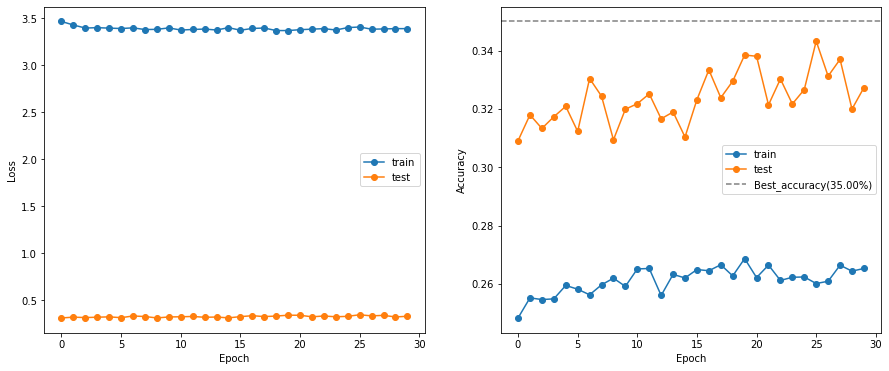

In [26]:
learning_rate = 0.001
epochs = 30

optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
benchmark_accuracy = 0.35

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    running_accuracy = 0
    running_loss = 0

    # training
    for x_train_batch, y_train_batch in trainloader:

        optimizer.zero_grad()

        # forward pass
        logits = model.forward(x_train_batch)
        train_preds = torch.argmax(logits.detach(), dim=1)

        # loss
        train_loss = criterion(logits, y_train_batch)
        running_loss += train_loss.item()

        # train accuracy
        train_acc = (y_train_batch == train_preds).sum() / len(y_train_batch)
        running_accuracy += train_acc.item()

        # backward pass
        train_loss.backward()
        
        # update parameters
        optimizer.step()

    # mean loss (all batches losses divided by the total number of batches)
    train_losses.append(running_loss / len(trainloader))
    
    # mean accuracies
    train_accuracies.append(running_accuracy / len(trainloader))
    
    # print
    print(f'Train loss: {train_losses[-1] :.4f}')

    # validation
    model.eval()
    with torch.no_grad():
        running_accuracy = 0
        running_loss = 0

        for x_test_batch, y_test_batch in testloader:
            
            # logits
            test_logits = model(x_test_batch)

            # predictions
            test_preds = torch.argmax(test_logits, dim=1)
            
            # accuracy
            test_acc = (y_test_batch == test_preds).sum() / len(y_test_batch)
            running_accuracy += test_acc.item()
            
            # loss
            test_loss = criterion(test_logits, y_test_batch)
            running_loss += test_loss.item()

        # mean accuracy for each epoch
        test_accuracies.append(running_accuracy / len(testloader))

        # mean loss for each epoch
        test_losses.append(running_accuracy / len(testloader))

        # print
        print(f'Test accuracy: {test_accuracies[-1]*100 :.2f}%')
        print('='*100)

        # saving best model
        # is current mean score (mean per epoch) greater than or equal to the benchmark?
        if test_accuracies[-1] > benchmark_accuracy:
            
            # save model 
            torch.save(model.state_dict(), './model.pth')

            # update benckmark
            benchmark_accuracy = test_accuracies[-1]

    model.train()


# Plots
x_epochs = list(range(epochs))
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(x_epochs, train_losses, marker='o', label='train')
plt.plot(x_epochs, test_losses, marker='o', label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_epochs, train_accuracies, marker='o', label='train')
plt.plot(x_epochs, test_accuracies, marker='o', label='test')
plt.axhline(benchmark_accuracy, c='grey', ls='--',
            label=f'Best_accuracy({benchmark_accuracy*100 :.2f}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./learning_curve.png', dpi = 200)

plt.show()
